In [ ]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from multiprocessing import Pool

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/ALMA/Data"

In [ ]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [ ]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.042                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

In [ ]:
#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/Alma_with_lens_center2.fits",
        noise_map_path=f"{data_folder}/rms_noise_map.fits",
        psf_path=f"{data_folder}/Alma_psf_rot.fits",
        pixel_scales=0.01,
        image_hdu=1, noise_map_hdu=1, psf_hdu=1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/mask2.fits", 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=False)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

In [ ]:
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=0.85, phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

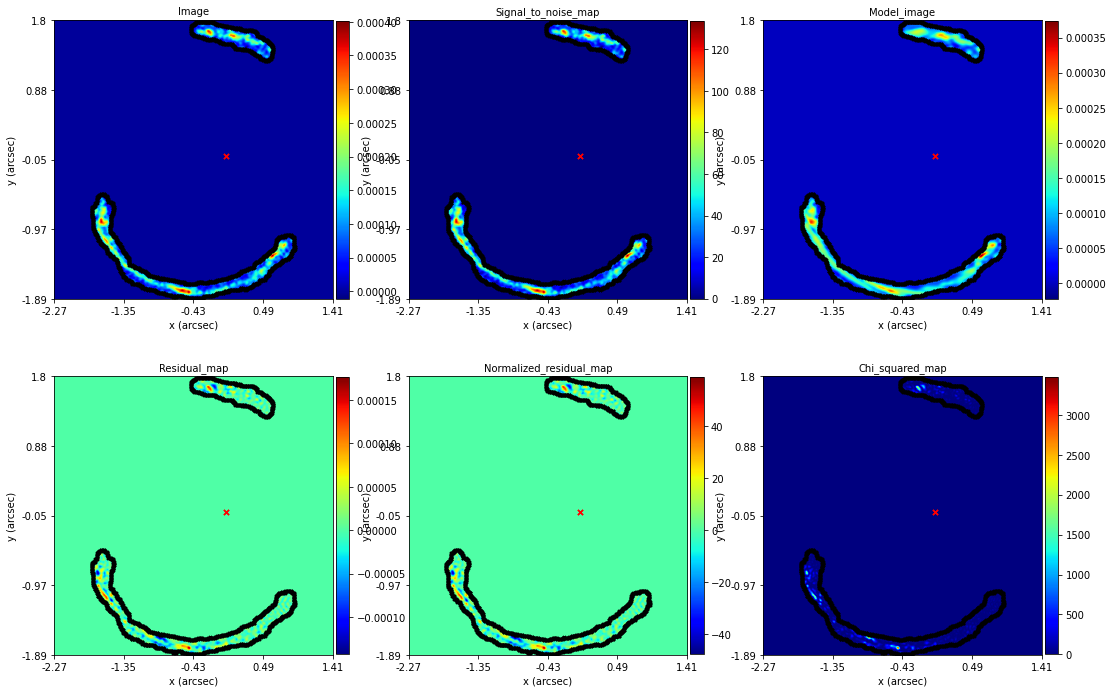

Log Likelihood with Regularization: -326645.0512968825
Log Evidence: -330613.8592386335
Log Likelihood : -326645.05094753124


In [6]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)

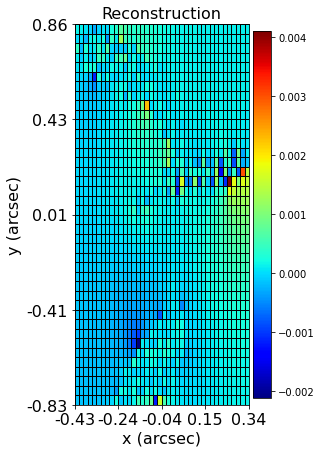

In [7]:
aplt.Inversion.reconstruction(fit.inversion, include=aplt.Include(inversion_grid=False, mask=False,
                                                                  border=False,inversion_border=False,
                                                                  inversion_pixelization_grid=False,
                                                                  inversion_image_pixelization_grid=False,))

In [8]:
boundary = {'ml': [0.5, 15], 'kappa_s': [0, 2], 'r_s': [5, 30], 'qDM': [0.1, 1], 'log_mbh':[7, 11],
                 'mag_shear': [0, 0.1], 'phi_shear': [0, 179], 'gamma': [0.95, 1.05]}


def prior_transform(theta):
    ml, kappa_s, qDM, r_s, log_mbh, mag_shear, phi_shear, gamma = theta
    parsDic = {"ml": ml, "kappa_s": kappa_s, "r_s": r_s, "qDM": qDM,
                    "log_mbh":log_mbh, "mag_shear": mag_shear, "phi_shear": phi_shear, 
                    "gamma": gamma}
    for key in parsDic:
        parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
        
    return np.array(list(parsDic.values()))

def log_likelihood(pars):
    quiet=False
    ml_model, kappa_s_model, r_s_model, qDM_model, log_mbh_model, mag_shear_model, phi_shear_model, gamma_model = pars
    
    ell_comps = al.convert.elliptical_comps_from(axis_ratio=qDM_model, phi=0.0) #Elliptical components in Pyautolens units
    eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s_model,elliptical_comps=ell_comps, scale_radius=r_s_model) #Set the analytical model
    mass_profile.Analytic_Model(eNFW)        #Include analytical model
    mass_profile.MGE_Updt_parameters(ml=ml_model, mbh=10**log_mbh_model, gamma=gamma_model)
    shear_comp_model = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_model, phi=phi_shear_model)
    #New lens model
    lens_galaxy = al.Galaxy(                                            
            redshift=mass_profile.z_l,
            mass=mass_profile,
            shear=al.mp.ExternalShear(elliptical_comps=shear_comp_model),
        )

    source_galaxy = al.Galaxy(
            redshift=mass_profile.z_s,
            pixelization=al.pix.Rectangular(shape=(40, 40)),
            regularization=al.reg.Constant(coefficient=1.5),
        )
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
    
    try:
        fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

        log_evidence = fit.log_evidence

            
        if quiet is False:
            print("Lens Galaxy Configuration:")
            print("Log Likelihood_with_regularization:", fit.log_likelihood)
            print("Log Normalization", fit.log_likelihood)
            print("Log Evidence:", fit.log_evidence)
            print("#------------------------------------#")
            print(lens_galaxy)
            print("\n")


            aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=False))
            aplt.Inversion.reconstruction(fit.inversion, include=aplt.Include(mask=False,
                                                                  border=False,inversion_border=False,
                                                                  inversion_pixelization_grid=False,
                                                                  inversion_grid=False,
                                                                  inversion_image_pixelization_grid=False,))              


        return log_evidence, fit
    except:
        print("An exception ocurres in Pyautolens_log_likelihood().")
        return -np.inf


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -326645.05094753124
Log Normalization -326645.05094753124
Log Evidence: -330613.8592386335
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 7.0
surf_dm: None
sigma_dm: None
qobs_dm: None
mbh: 1000000000.0
sigma_mbh: 0.01
qobs_mbh: 1.0
D_l

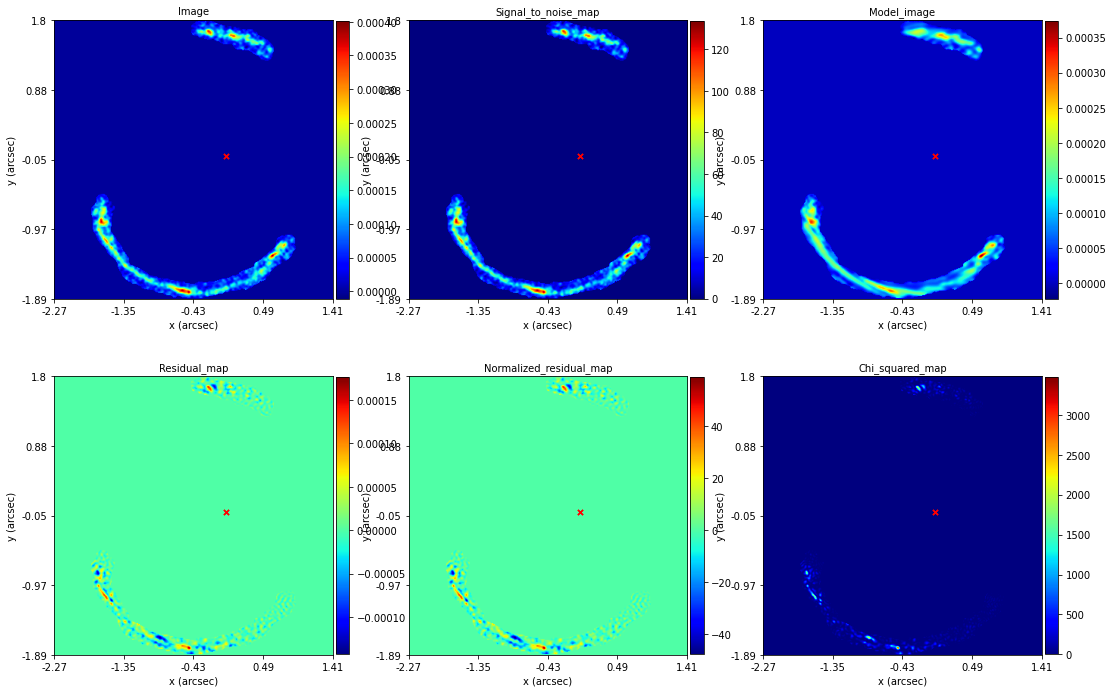

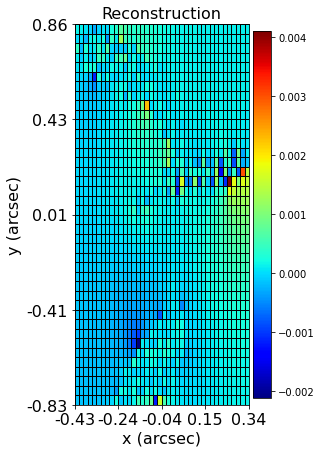

Array(-330613.85923863)

In [9]:
# ml, kappa_s, r_s qDM, log_mbh, mag_shear, phi_shear, gamma = pars
p0 = np.array([ml, kappa_, r_s, 0.85, np.log10(mbh), 0.02, 88., 1.0])
log_likelihood(p0)

In [9]:
from dynesty import NestedSampler

nlive = 100              # number of (initial) live points
ndim  = p0.size          #number of dimensions


# Now run with the static sampler
sampler = NestedSampler(log_likelihood, prior_transform, ndim, pool=Pool(),queue_size=6,
                        nlive=nlive)

In [9]:
import pickle 
import shutil

from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]



original = r"dynesty_lens.pickle"
beckup   = r"beckup/dynesty_lens_beckup.pickle"

start = time.time()
for it, res in enumerate(sampler.sample()):
    if (it+1) % 100:
        continue
    
    print("Saving...")
    with open(f"dynesty_lens.pickle", "wb") as f:
                pickle.dump(sampler, f)
    print("File Save!")
    print(sampler.results.summary())
    print("Cumulative Time [s]:", (time.time() - start))
    print("#############################")
    print("\n")
    
    beckup = shutil.copyfile(original, beckup)
    
    


## Loading Run 1

In [54]:
import pickle
with open(f'dynesty_lens.pickle','rb') as f:
    sample_load = pickle.load(f)
    
with open(f'dynesty_lens2.pickle','rb') as f:
    sample_load2 = pickle.load(f)

In [56]:
sample_load.results["logz"].shape, sample_load2.results["logz"].shape

((992,), (593,))

In [57]:
sample_load.results["logz"][-1] - sample_load.results["logz"][992-2], sample_load2.results["logz"][-1] - sample_load2.results["logz"][593-2]

(5939.99509165046, 778.5342115567182)

In [58]:
sample_load.results.summary(), sample_load2.results.summary()

Summary
nlive: 200
niter: 792
ncall: 24188
eff(%):  4.101
logz: -18850.892 +/-  0.318
Summary
nlive: 40
niter: 553
ncall: 25518
eff(%):  2.324
logz: 14753.081 +/-  0.958


(None, None)

In [86]:
rlist = [sample_load.results, sample_load2.results]

# Merge into a single run.
results = dyfunc.merge_runs(rlist)

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


ValueError: Axis limits cannot be NaN or Inf

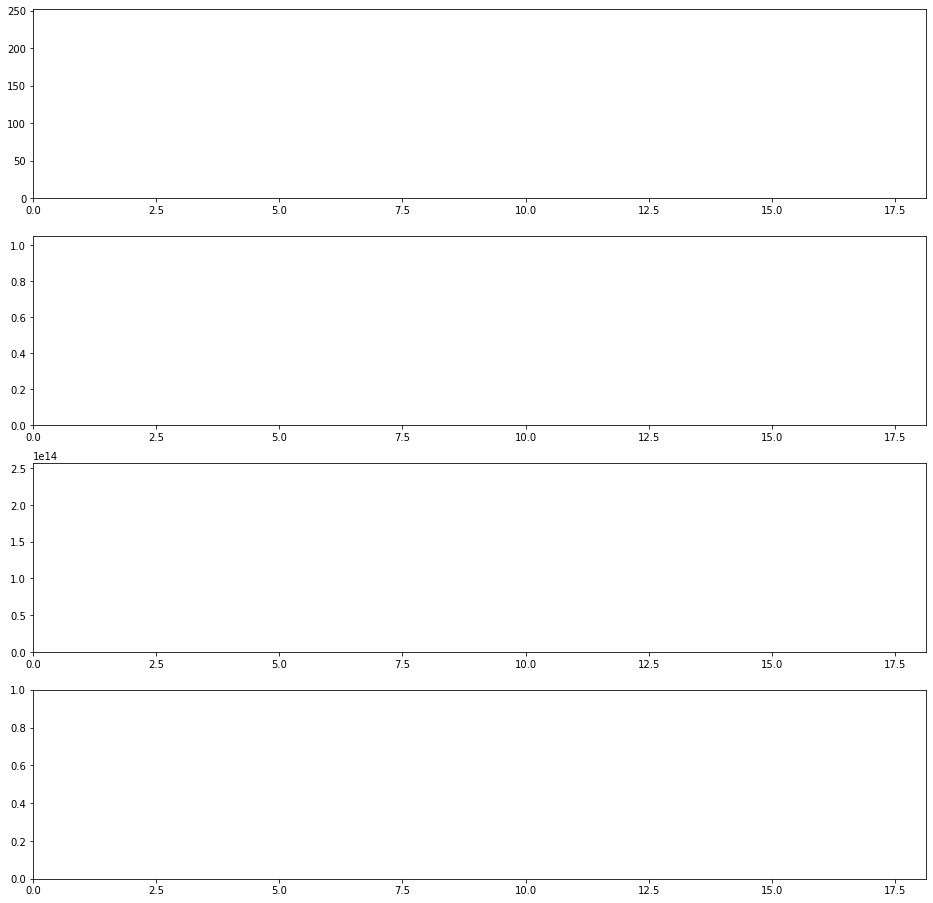

In [87]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
dyplot.runplot(results)

#rfig.savefig("save.png")

In [77]:
from dynesty import utils as dyfunc
labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

(array([ 3.27491854,  0.1255322 , 16.72996666,  0.19629543,  7.19603654,
         0.07540212, 41.95720129,  0.98265909]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.38020881e-33,
         1.08166682e-31, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08166682e-31,
         3.46133382e-30, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+0

Text(0, 0.5, '$- \\Delta \\ln X$')

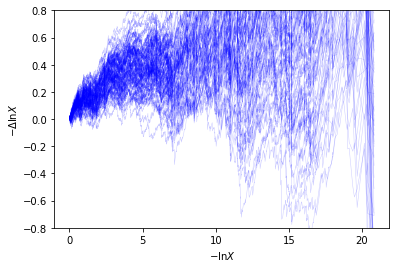

In [71]:
from dynesty import utils as dyfunc

# plot ln(prior volume) changes
for i in range(100):
    dres_j = dyfunc.jitter_run(results_sim)
    plt.plot(-results_sim.logvol, -results_sim.logvol + dres_j.logvol, color='blue',
             lw=0.5, alpha=0.2)
plt.ylim([-0.8, 0.8])
plt.xlabel(r'$-\ln X$')
plt.ylabel(r'$- \Delta \ln X$')

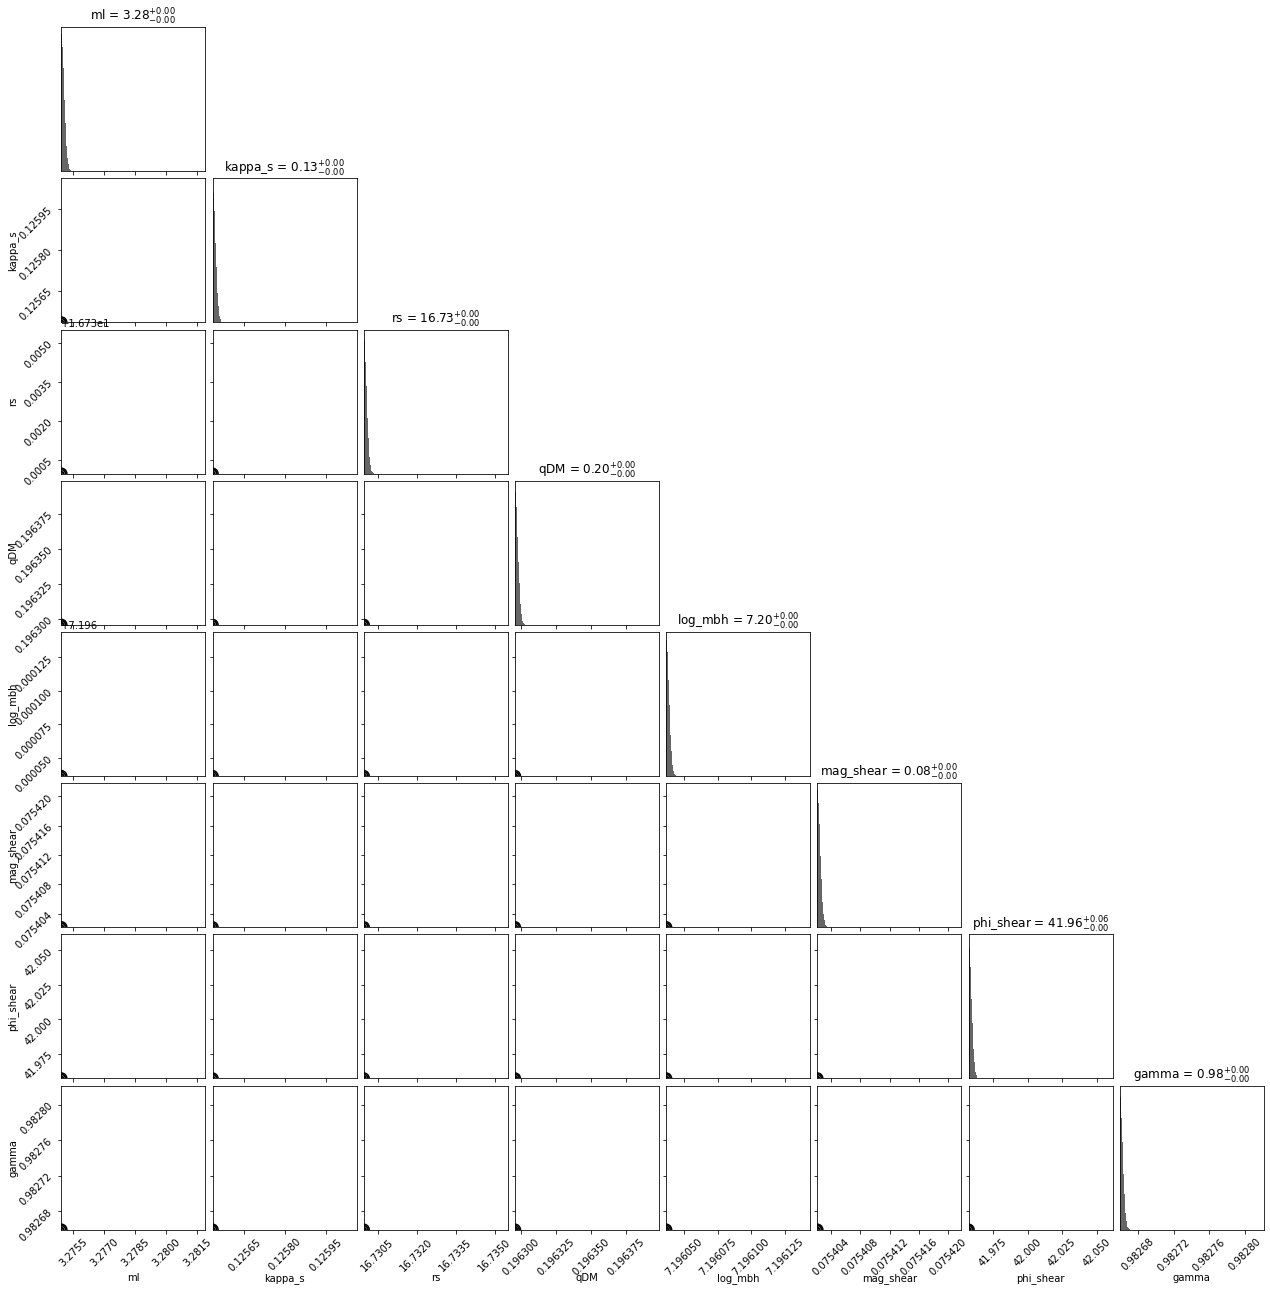

In [78]:
# Plot the 2-D marginalized posteriors.
labels = ["ml", "kappa_s", "rs", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(results_sim, quantiles=None,show_titles=True,labels=labels,
                               )

ValueError: The iteration requested goes beyond the number of iterations in the run.

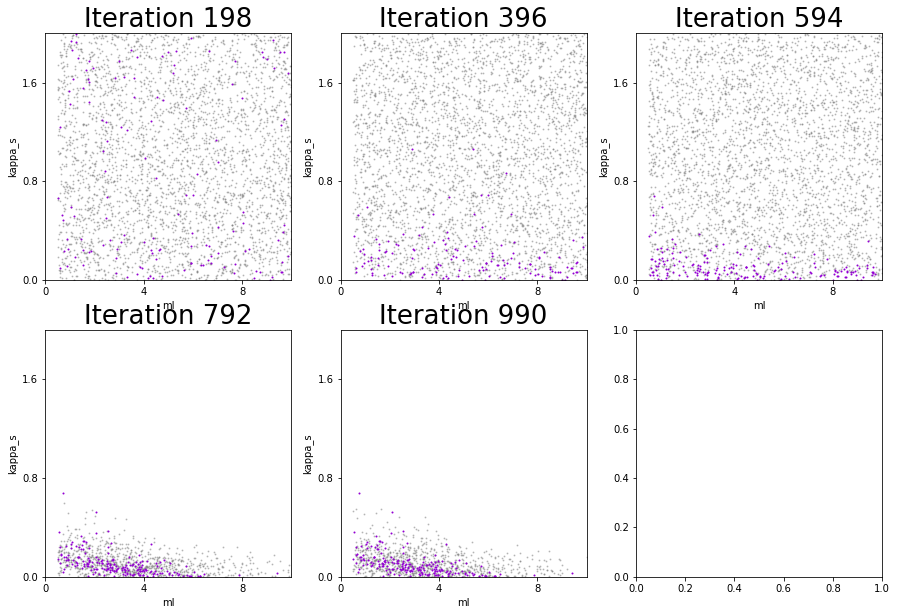

In [80]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*results.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.boundplot(sample_load.results, dims=(0, 1), it=it, prior_transform=prior_transform, max_n_ticks=3,
                            show_live=True, span=[(0, 10), (0, 2)], fig=(fig, a), labels=labels)
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()

ValueError: No bounds were saved in the results!

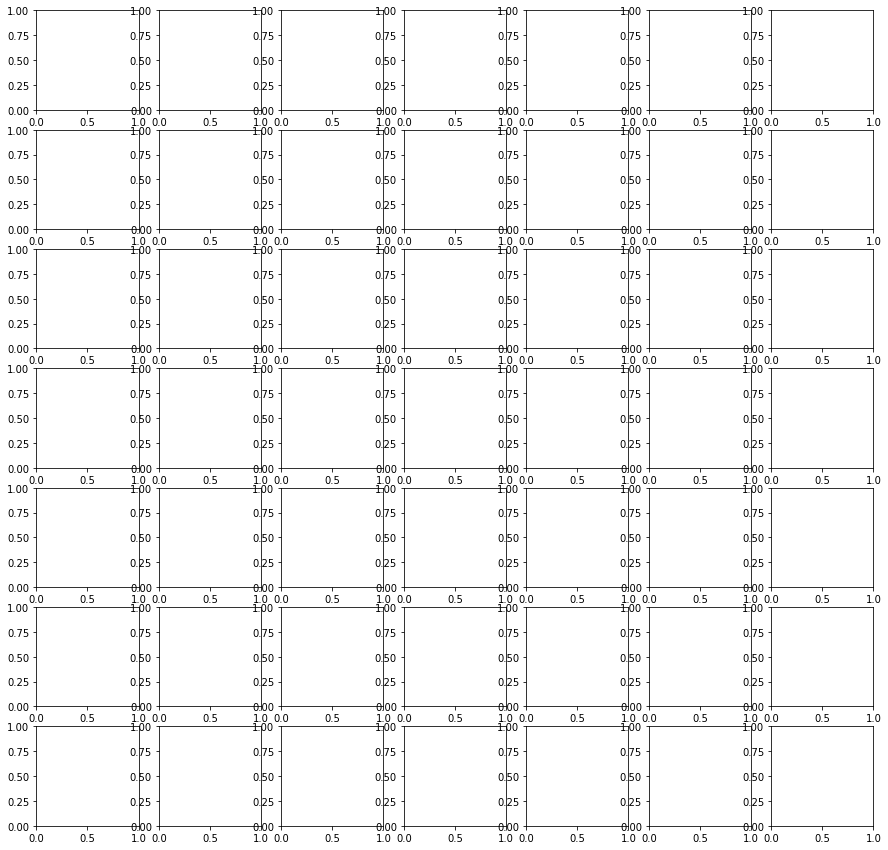

In [81]:
# initialize figure
fig, axes = plt.subplots(7, 7, figsize=(15, 15))

# plot proposals in corner format
fg, ax = dyplot.cornerbound(sample_load.results,it=590, prior_transform=prior_transform, show_live=True,
                             fig=(fig, axes), labels=labels)

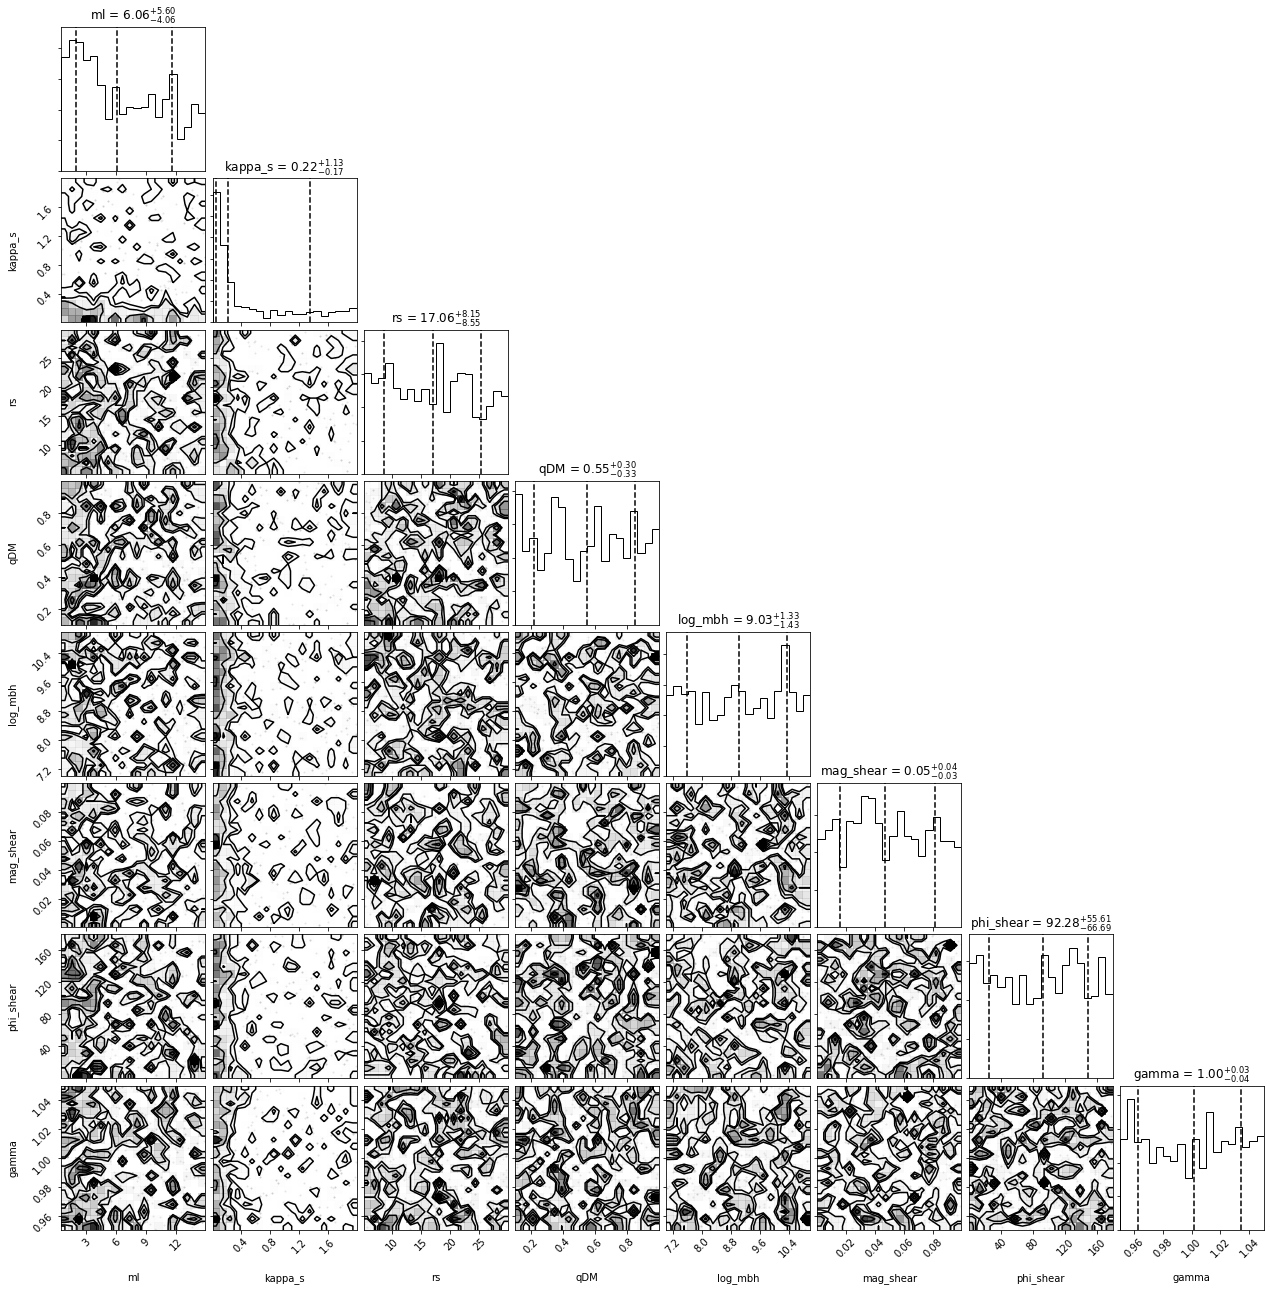

In [49]:
import corner

fig = corner.corner(
    results_sim.samples, labels=labels, quantiles=[0.16, 0.50, 0.84],show_titles=True,
);

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynes

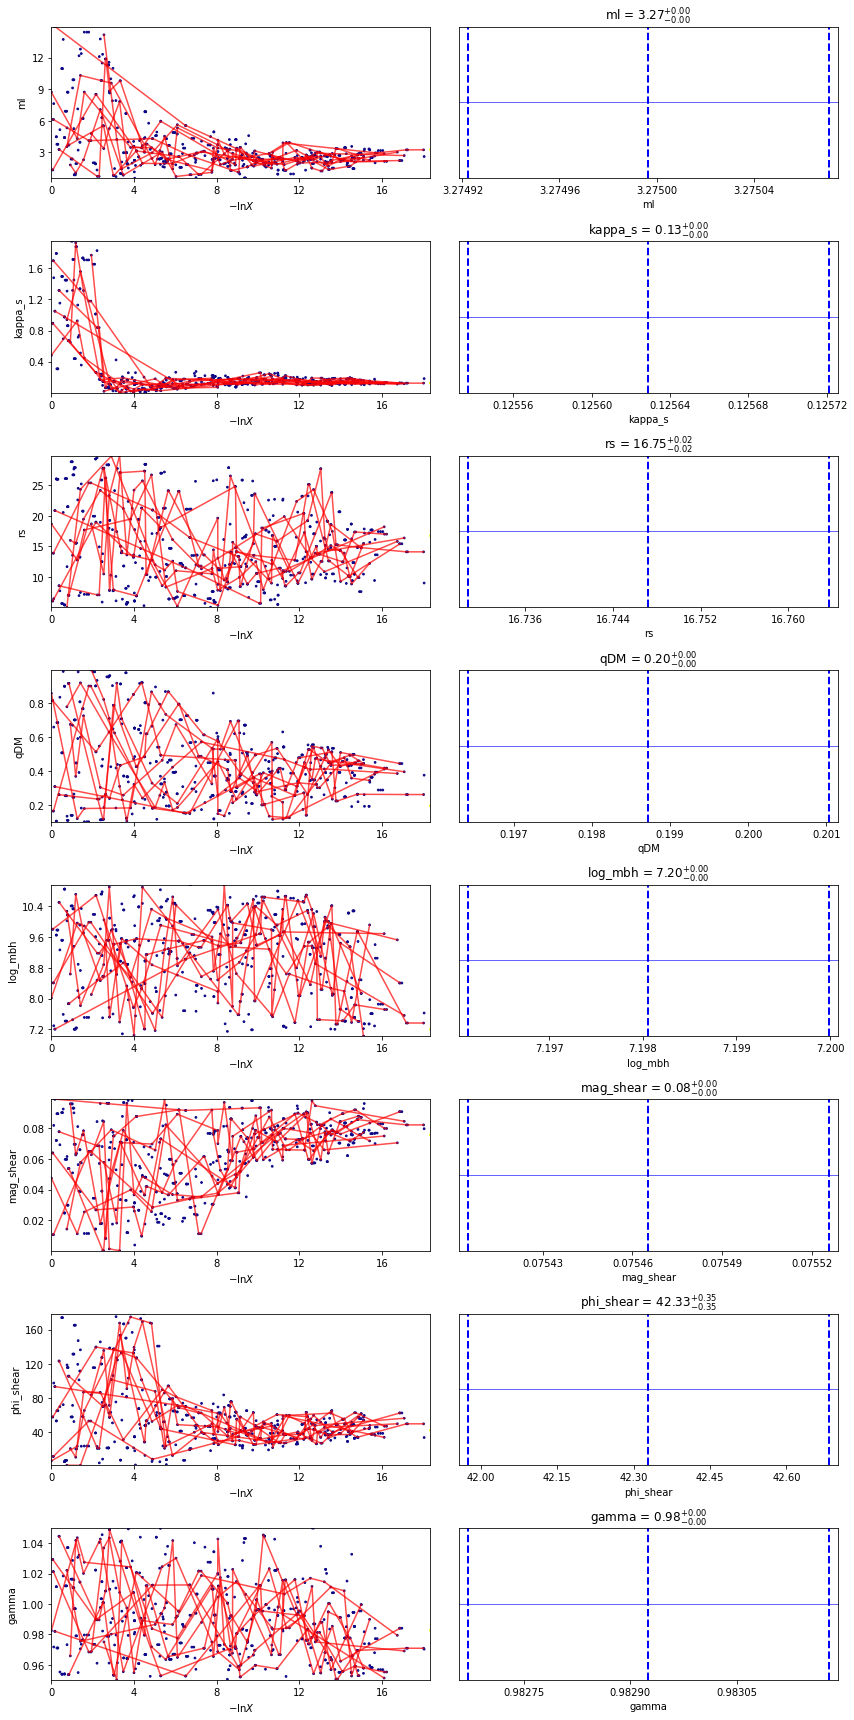

In [52]:
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,kde=None, 
                               show_titles=True, connect=True, )
plt.tight_layout()

Lens Galaxy Configuration:
Log Likelihood_with_regularization: 26053.139380116132
Log Normalization 26053.139380116132
Log Evidence: 16476.720845819873
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.9826590857260625
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.6718278349734875)
axis_ratio: 0.19629543076229303
phi: 0.0
kappa_s: 0.12553220025723982
scale_radius: 16.729966658883775
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 3.274918542536762
surf_dm: None
sigma_dm: None
qobs_dm: N

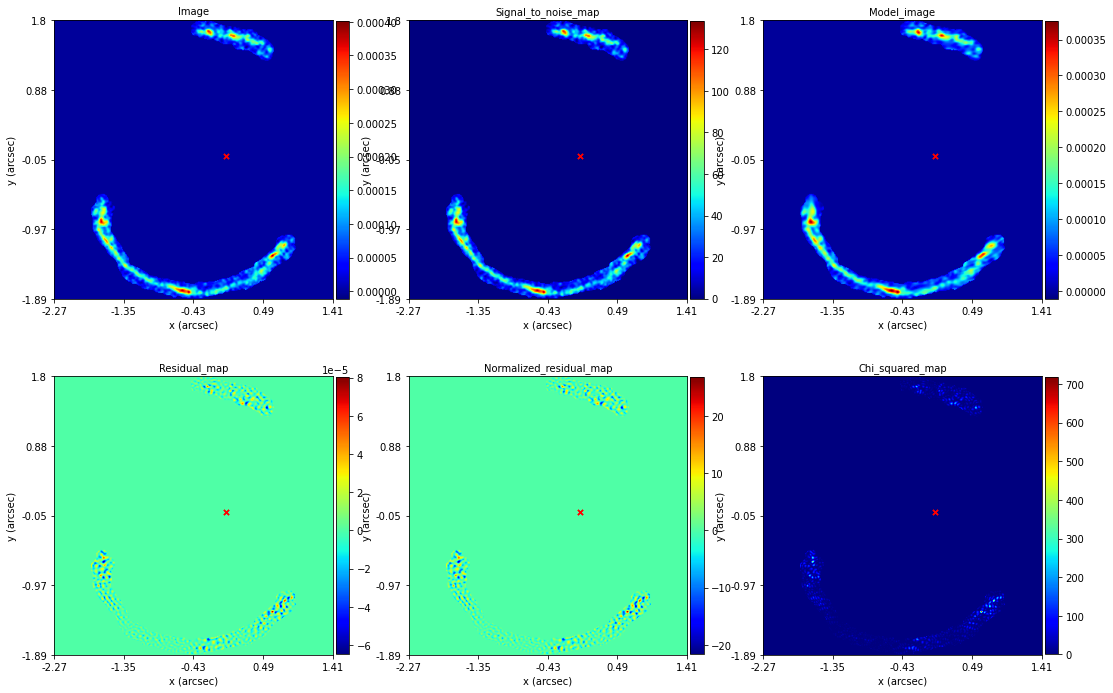

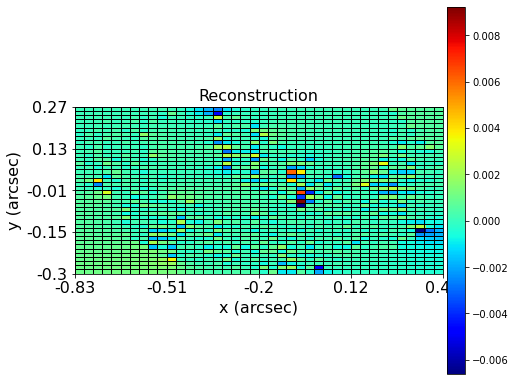

16476.720845819873


<Figure size 432x288 with 0 Axes>

In [53]:
log_evi, fit_fun = log_likelihood(mean)
print(log_evi)
plt.tight_layout()

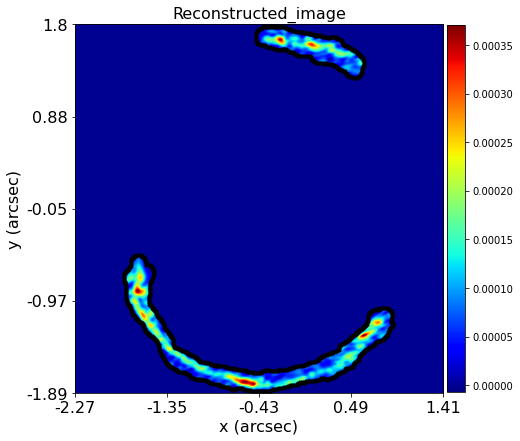

In [28]:
aplt.Inversion.reconstructed_image(fit_fun.inversion)

In [29]:
source = fit_fun.inversion.reconstruction
model = fit_fun.inversion.image

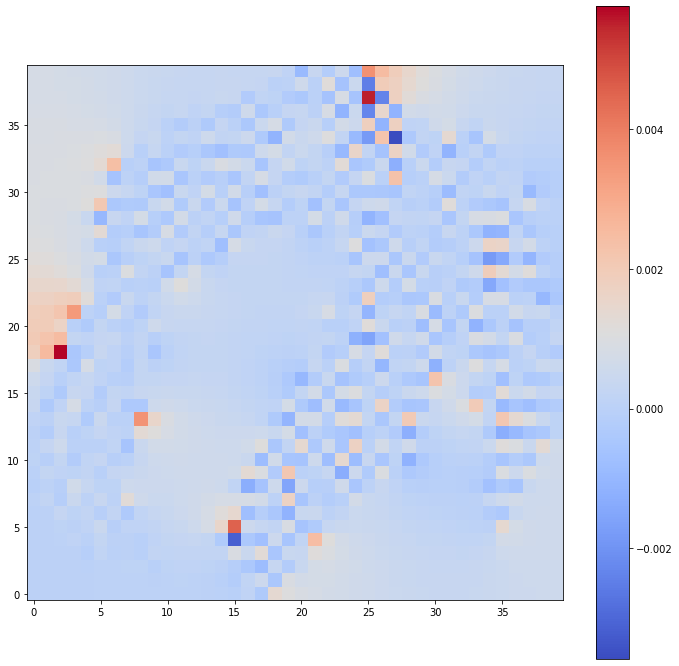

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(source.reshape(40,40), cmap='coolwarm',origin='lower')
plt.colorbar()

In [31]:
from mpdaf.obj import Image

In [32]:
img = Image(data=source.reshape(40,40))

In [72]:
img.write("source.fits")

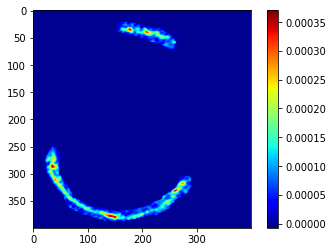

In [33]:
plt.imshow(fit_fun.model_data.in_2d, cmap="jet")
plt.colorbar()

In [109]:
model = fit_fun.model_data.in_2d
model_fits = Image(data=model,)
model_fits.write("model.fits")

In [112]:
residual = fit_fun.residual_map.in_2d
residual_fits = Image(data=residual)
residual_fits.write("residual.fits")